# Adaptive PDE discretizations on Cartesian grids
## Volume : Non-divergence form PDEs
## Part : Eikonal equation and variants
## Chapter : Shape from shading with oblique lighting

In this notebook, we propose a discretization of the shape from shading PDE, which reads
\begin{equation}
    I(p) = I_0 a \frac{\alpha \partial_x u(p) + \beta \partial_y u(p) + \gamma}{\sqrt{1+\|\nabla u(p)\|^2}}
\end{equation}
for all $p \in \Omega$, and $u(p) = 0$ for all $p \in \partial \Omega$.

we denoted:
- $\Omega\subset \mathbb R^2$ is a bounded domain.
- $u : \Omega \to \mathbb R$ is an unknown surface elevation, to be computed.
- $I_0$ is the light source intensity, and $a$ the albedo of the surface.
- $I: \Omega \to \mathbb R_+$ the reflected intensity.
- The vector $(\alpha, \beta, -\gamma)$ is unit and defines the incident direction of the light rays, and $\gamma>0$. Without loss of generality, up to a reflection of the axes, we can assume that $\alpha\geq 0$ and $\gamma\geq 0$.

The modeling is that the normal to the surface is proportional $(-\nabla u(p), 1)$, hence the deposited light density is proportional to the cosine of the angle difference
\begin{equation}
\frac{(-\nabla u(p),1)}{\sqrt{1+\|\nabla u(p)\|^2}} \cdot (\alpha, \beta, -\gamma).
\end{equation}
We make the assumption $I(p)>0$ everywhere, which amounts to say that no shadows are cast. It implies that the above scalar product is positive.

**Note** The numerical method developed in this notebook does not take advantage of the specific techniques developed for Anisotropic Monotone PDEs.

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Reformulation of the PDE and discretization](#1.-Reformulation-of-the-PDE-and-discretization)
  * [2. Implementation](#2.-Implementation)
  * [3. Testing](#3.-Testing)
    * [3.1 Problem setting](#3.1-Problem-setting)
    * [3.2 Consistency checks](#3.2-Consistency-checks)
    * [3.3 Numerical solution](#3.3-Numerical-solution)
    * [3.4 Other numerical examples](#3.4-Other-numerical-examples)
  * [4. GPU acceleration](#4.-GPU-acceleration)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libaries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('ShapeFromShading','NonDiv')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Reformulation of the PDE and discretization

We rewrite the PDE as 
$$
c(p) \sqrt{1+\|\nabla u(p)\|^2} = (\alpha,\beta) \cdot \nabla u(p) + \gamma,
$$
where $c(p) :=  I(p)/(I_0 a)$. 

Let us denote this equation as $lhs=rhs$. In order to solve it we need to design a monotone scheme for one of the following.

**Note on squaring both sides of the inequality.**
It is very tempting to get rid of the square root, and consider the system $lhs^2 - rhs^2 = 0$, which is a quadratic function with respect to $\nabla u(p)$. However, the second degree part in this equation is not positive definite in general, unless we do strong assumptions on the coefficients.
After some thinking, this approach is abandoned.


**Discretization.** We consider the PDE $lhs - rhs = 0$, which we discretize as follows:
$$
    c(p)\sqrt{1+(\delta^+_x u(p))^2 + (\delta_y^+ u(p))^2} +\alpha D^+_{-x} u(p) + \beta D^+_{-x} u(p) - \gamma = 0,
$$
where we denoted 
\begin{align}
    \delta_x^+ u(p) &:= h^{-1}\max \{0,u(p)-u(p-h e_x), u(p)-u(p+h e_x)\}, \\
    D^+_{-x} u(p) &= h^{-1}(u(p)-u(p+h e_x)),
\end{align}
with $e_x = (1,0)$ the unit vector along the $x$-axis, and $h$ the gridscale. Likewise in the $y$ direction.

**Existence of a solution.** 
The above discrete system of equations admits a  sub-solution and a super solution, obtained as affine functions
$$
    u(p) = C + p\cdot v.
$$

The constant term $C$ should be chosen so as to be below or above zero respectively at the boundary. The gradient should be chosen as follows.
-  sub-solution. Choose $v = (\alpha,\beta)/\gamma$ so that one has the equality $(\alpha,\beta)\cdot v+\gamma = \sqrt{1+\|v\|^2}$ - indeed  $\alpha^2+\beta^2+\gamma^2 =1$ by assumption. Conclude recalling that $c(p)<1$.
-  super-solution. Choose an $v$ such that $(\alpha,\beta) \cdot v + \gamma = 0$. (The argument in the case of purely vertical illumination $\alpha=\beta=0$ is different.) Conclude recalling that $c(p)>0$. 

<!---
\begin{equation}
    c(p)\sqrt{1+\|v\|^2} - (\alpha,\beta)\cdot v -\gamma >0.
\end{equation}

For instance, we can choose a multiple of $(\alpha,\beta)$ with sufficiently large norm. (the vector $v$ can point in an arbitrary direction if $(\alpha,\beta)=0$.
--->

Since the discretization is monotone, there is a solution.

**Jacobi iteration.**
We start with $u_0 = 0$, and iteratively obtain $u_{n+1}$ by solving pointwise a univariate equation. This equation is such that $u_{n+1}(p)$, with neighboring values unchanged, solves the discretized equation.

By monotony of the discretization, and since the initialization is a sub-solution, this  defines an increasing sequence of sub-solutions. The sequence converges, and the limit is a solution.

## 2. Implementation

The Jacobi iteration requires solving the following equation
\begin{equation}
    c(p)\sqrt{1+\frac{(\lambda-v_x)^2_+ +(\lambda-v_y)^2_+}{h^2}} + \alpha \frac{\lambda-w_x} h +\beta\frac{\lambda-w_y} h - \gamma = 0,
\end{equation}
where $a_+ := \max\{0,a\}$ for any $a \in \mathbb R$, and where
\begin{align}
    v_x & := \min\{u(x+h e_x),u(x-he_x)\}, & 
    w_x & := u(x+h e_x),
\end{align}
and likewise for $v_y$, $w_y$.

We write this as $lhs^2 == rhs^2$, solve a quadratic equation. Then we select the single root $\lambda$ such that 
\begin{equation}
\gamma \geq \alpha \frac{\lambda-w_x} h + \beta \frac{\lambda-w_y} h.
\end{equation}
This must be the smallest root.
If the obtained value satisfies $\lambda<v_x$ or $\lambda<v_y$, then the corresponding term is removed from the equation and the process is repeated.

**The quadratic equation.** It reads
$$
c(p)^2 (1+\frac{(\lambda-v_x)^2_+ +(\lambda-v_y)^2_+}{h^2}) - (\alpha \frac{\lambda-w_x} h +\beta\frac{\lambda-w_y} h - \gamma)^2 = 0
$$

In the case where $\lambda \geq \max(v_x,v_y)$ we obtain,
$$
    \lambda^2 (2 c(p)^2  - (\alpha+\beta)^2)
    {-} 2 \lambda (c(p)^2 (v_x+v_y) - (\alpha+\beta)(\alpha w_x+\beta w_y +h\gamma)) + 
    (c(p)^2 (h^2+v_x^2+v_y^2) - (\gamma h +\alpha w_x+\beta w_y)^2) = 0.
$$
We solve this equation, and check wether the assumption $\lambda \geq \max(v_x,v_y)$ does hold. If that is not the case, then one must have, for  instance, $v_x \leq \lambda \leq v_y$, the term $(\lambda-v_y)^2_+$ can be discarded.


In [3]:
def EvalScheme(cp,u,uc,params):
    """
    Evaluates the (piecewise) quadratic equation defining the numerical scheme.
    Inputs :
     - uc : plays the role of λ
    """
    alpha,beta,gamma,h = params
    wx = np.roll(u,-1,axis=0)
    wy = np.roll(u,-1,axis=1)
    vx = np.minimum(wx,np.roll(u,1,axis=0))
    vy = np.minimum(wy,np.roll(u,1,axis=1))

    return (cp*np.sqrt(1+(np.maximum(0,uc-vx)**2+np.maximum(0,uc-vy)**2)/h**2) +
            alpha*(uc-wx)/h+beta*(uc-wy)/h-gamma)

In [4]:
def LocalSolve(cp,vx,vy,wx,wy,params):
    """
    Solve the (piecewise) quadratic equation defining the numerical scheme.
    Output: solution λ.
    """
    alpha,beta,gamma,h = params
    # Trying with two active positive parts 
    
    # Quadratic equation coefficients.
    # a lambda^2 - 2 b lambda + c =0
    a = (2.*cp**2 - (alpha+beta)**2)
    b = cp**2 *(vx+vy) - (alpha+beta)*(alpha*wx+beta*wy+h*gamma)
    c = cp**2*(h**2+vx**2+vy**2)-(gamma*h+alpha*wx+beta*wy)**2
    
    delta = b**2 - a*c
    good = np.logical_and(delta>=0,a!=0)
    u = 0*cp;
    # TODO : Is that the correct root selection ?
    u[good] = (b[good]+np.sqrt(delta[good]))/a[good] 

    vmax = np.maximum(vx,vy)
    good = np.logical_and(good,u>=vmax)
    
    # Trying with one active positive part
    # TODO : restrict computations to not good points to save cpu time ?
    
    vmin = np.minimum(vx,vy)
    a = (cp**2 - (alpha+beta)**2)
    b = cp**2 *vmin - (alpha+beta)*(alpha*wx+beta*wy+h*gamma)
    c = cp**2*(h**2+vmin**2)-(gamma*h+alpha*wx+beta*wy)**2

    delta = b**2 - a*c
    ggood = np.logical_and(np.logical_and(delta>=0,a!=0), 1-good)
    u[ggood] = (b[ggood] +np.sqrt(delta[ggood]))/a[ggood]
    
    good = np.logical_or(good,np.logical_and(ggood,u>=vmin))
    
    # No active positive part
    # equation becomes linear, a lambda - b = 0
    a = alpha+beta+0.*cp
    b = alpha*wx+beta*wy +gamma*h - cp*h
    bad = np.logical_not(good)
    u[bad]=b[bad]/a[bad]
    return u
    
def JacobiIteration(u,Omega,c,params):
    """
    One Jacobi iteration, returning the pointwise solution λ to the numerical scheme.
    """
    wx = np.roll(u,-1,axis=0)
    wy = np.roll(u,-1,axis=1)
    vx = np.minimum(wx,np.roll(u,1,axis=0))
    vy = np.minimum(wy,np.roll(u,1,axis=1))
    
#    sol=LocalSolve(c,vx,vy,wx,wy,params)
    sol = u+LocalSolve(c,vx-u,vy-u,wx-u,wy-u,params)
    u[Omega] = sol[Omega]

## 3. Testing



### 3.1 Problem setting

Let choose a coordinate system, and the model parameters.

In [5]:
# Coordinate system
h=1/100.
X,Y = np.meshgrid(np.arange(0,1,h),np.arange(0,1,h),indexing='ij')

# Shading parameters
ω = 0.15*np.array([1,2])
α,β,γ = np.append(ω,1)/np.linalg.norm(np.append(ω,1))

params = α,β,γ,h

In [6]:
α,β,γ

(0.14221363894199318, 0.28442727788398636, 0.9480909262799545)

The test functions.

In [7]:
def OneBump(x,y):
    bump = 0.5-3.*((x-0.5)**2+(y-0.5)**2)
    return np.maximum(bump, np.zeros_like(x))

def ThreeBumps(x,y):
    bump1 = 0.3-3*((x-0.4)**2+(y-0.5)**2)
    bump2 = 0.25-3*((x-0.65)**2+(y-0.6)**2)
    bump3 = 0.25-3*((x-0.6)**2+(y-0.35)**2)
    return np.maximum.reduce([bump1,bump2,bump3,np.zeros_like(bump1)])

def Volcano(x,y):
    r = np.sqrt((x-0.5)**2+(y-0.5)**2)
    volcano = 0.05+1.5*(1+x)*(r**2-6*r**4)
    return np.maximum(volcano, np.zeros_like(x))

We generate a synthetic problem, and a synthetic r.h.s, by evaluating the differential operator on the test function. 

In [8]:
def GenerateRHS(height,params):
    α,β,γ,h = params
    hx,hy = np.gradient(height,h)
    Intensity = (α*hx+β*hy+γ)/np.sqrt(1+hx**2+hy**2)
    Omega = height>0
    return Intensity,Omega

In [9]:
height = Volcano(X,Y)
Intensity,Omega = GenerateRHS(height,params)

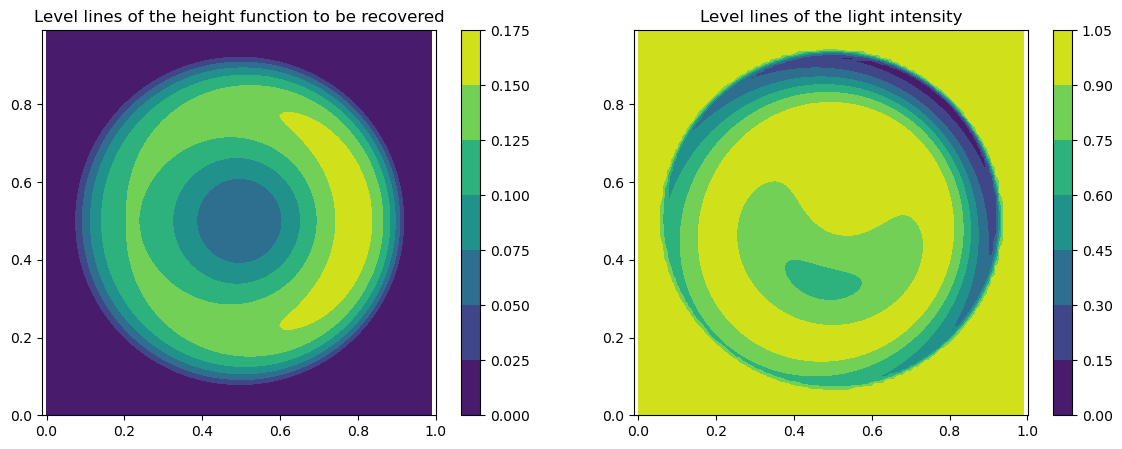

In [10]:
plt.figure(figsize=[14,5])

plt.subplot(1,2,1)
plt.title("Level lines of the height function to be recovered")
plt.contourf(X,Y,height); plt.colorbar(); plt.axis('equal')

plt.subplot(1,2,2)
plt.title("Level lines of the light intensity")
plt.contourf(X,Y,Intensity); plt.colorbar(); plt.axis('equal');

### 3.2 Consistency checks

Our discretization requires that the reflected intensity is positive everywhere.

In [11]:
print(f"Minimal reflected intensity : {np.min(Intensity)}")
assert np.min(Intensity)>0

Minimal reflected intensity : 0.0642842362123776


Let us check that the numerical scheme, evaluated on the solution, yields a small residue. The residue is not exactly zero because numpy relies on centered finite differences (except along the boundary), which differ from the upwind finite differences used within our numerical scheme. This residue is largest where the height map is not differentiable, in particular along the boundary of the domain $\Omega$.

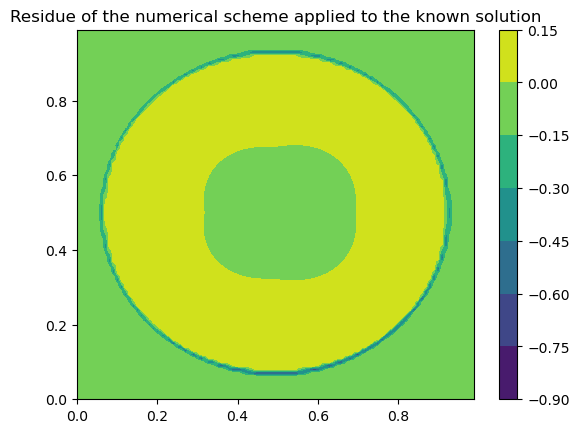

In [12]:
plt.title("Residue of the numerical scheme applied to the known solution")
plt.contourf(X,Y,EvalScheme(Intensity,height,height,params));
plt.colorbar();

### 3.3 Numerical solution

For faster convergence, we start with an over-estimate of the solution.

In [13]:
U=np.ones_like(X); U[np.logical_not(Omega)]=0; # Start with an overestimate : fast convergence
#U=np.zeros_like(X)  # Start with an under-estimate : slow convergence

After enough Jacobi iterations, we obtain the numerical solution to the scheme.

In [14]:
for i in range(800):
    JacobiIteration(U,Omega,Intensity,[α,β,γ,h])

In [15]:
residue = EvalScheme(Intensity,U,U,params)[Omega]
assert np.allclose(residue,0.)

The proposed approach is able to reconstruct a large portion of the height maps, but not everything. In particular, the hole in the middle of the volcano is *not* reproduced. This is an intrinsic limitation of the approach based on viscosity solutions.

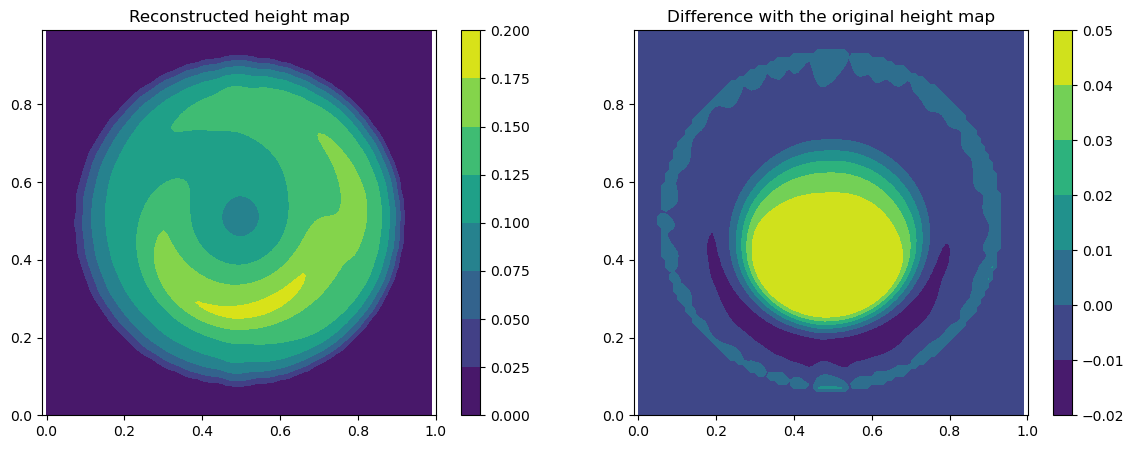

In [16]:
plt.figure(figsize=[14,5])

plt.subplot(1,2,1)
plt.title('Reconstructed height map')
plt.contourf(X,Y,U); plt.colorbar(); plt.axis('equal')

plt.subplot(1,2,2)
plt.title('Difference with the original height map')
plt.contourf(X,Y,U-height); plt.colorbar(); plt.axis('equal');

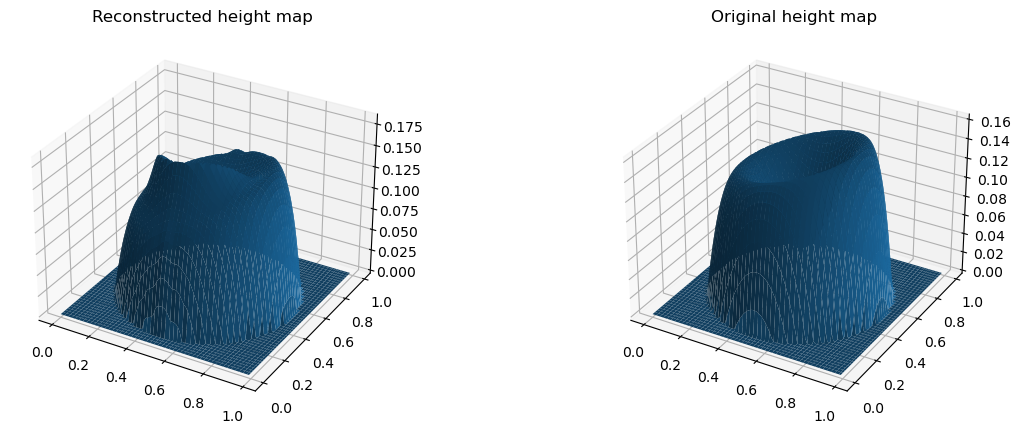

In [17]:
fig = plt.figure(figsize=[14,5])

ax = fig.add_subplot(121,projection='3d')
plt.title('Reconstructed height map')
ax.plot_surface(X,Y,U);

ax = fig.add_subplot(122,projection='3d')
plt.title('Original height map')
ax.plot_surface(X,Y,height);

### 3.4 Other numerical examples

In the case of the *three bumps* test function, the crater-like part, which cannot be recovered, is smaller and mostly located between two of the bumps.

In [18]:
height = ThreeBumps(X,Y)
Intensity,Omega = GenerateRHS(height,params)

In [19]:
U=np.ones_like(X); U[np.logical_not(Omega)]=0;
for i in range(800):
    JacobiIteration(U,Omega,Intensity,params)

In [20]:
residue = EvalScheme(Intensity,U,U,params)[Omega]
assert np.allclose(residue,0.)

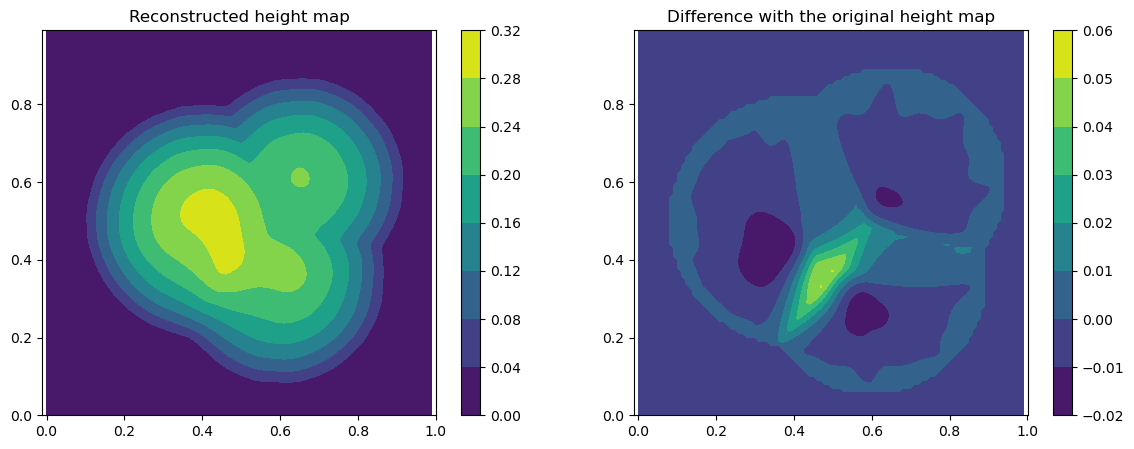

In [21]:
plt.figure(figsize=[14,5])

plt.subplot(1,2,1)
plt.title('Reconstructed height map')
plt.contourf(X,Y,U); plt.colorbar(); plt.axis('equal')

plt.subplot(1,2,2)
plt.title('Difference with the original height map')
plt.contourf(X,Y,U-height); plt.colorbar(); plt.axis('equal');

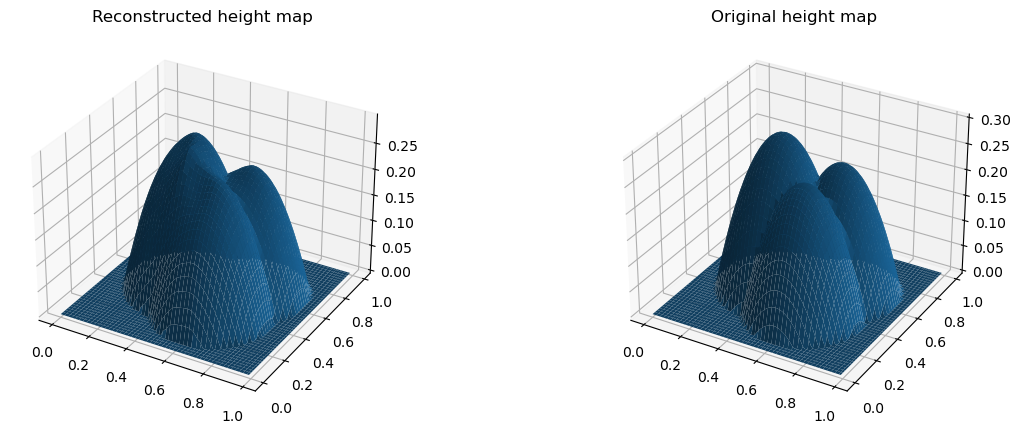

In [22]:
fig = plt.figure(figsize=[14,5])

ax = fig.add_subplot(121,projection='3d')
plt.title('Reconstructed height map')
ax.plot_surface(X,Y,U);

ax = fig.add_subplot(122,projection='3d')
plt.title('Original height map')
ax.plot_surface(X,Y,height);

Finally, the single bump function can be recovered quite accurately, since it does not have a crater-like part.

In [23]:
height = OneBump(X,Y)
Intensity,Omega = GenerateRHS(height,params)

In [24]:
U=np.ones_like(X); U[np.logical_not(Omega)]=0;
for i in range(800):
    JacobiIteration(U,Omega,Intensity,params)

In [25]:
residue = EvalScheme(Intensity,U,U,params)[Omega]
assert np.allclose(residue,0.)

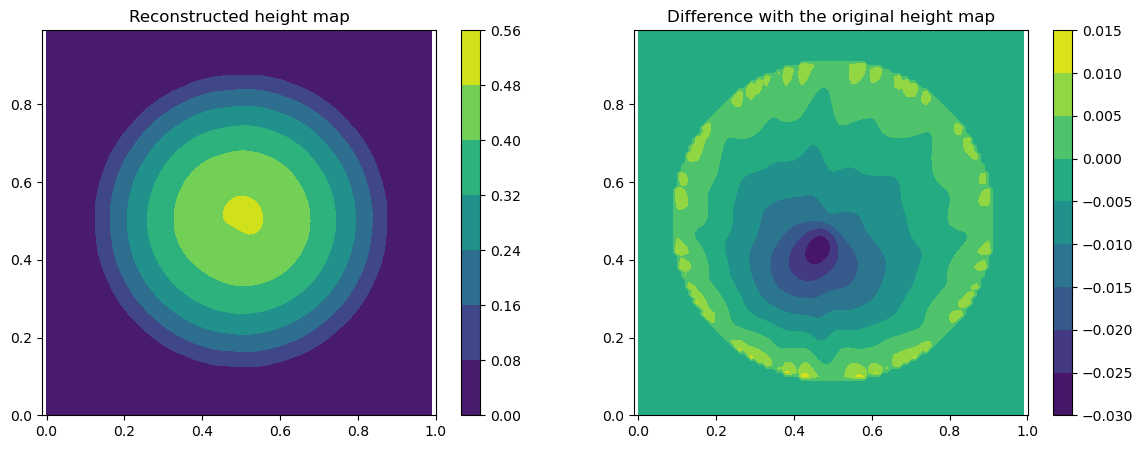

In [26]:
plt.figure(figsize=[14,5])

plt.subplot(1,2,1)
plt.title('Reconstructed height map')
plt.contourf(X,Y,U); plt.colorbar(); plt.axis('equal')

plt.subplot(1,2,2)
plt.title('Difference with the original height map')
plt.contourf(X,Y,U-height); plt.colorbar(); plt.axis('equal');

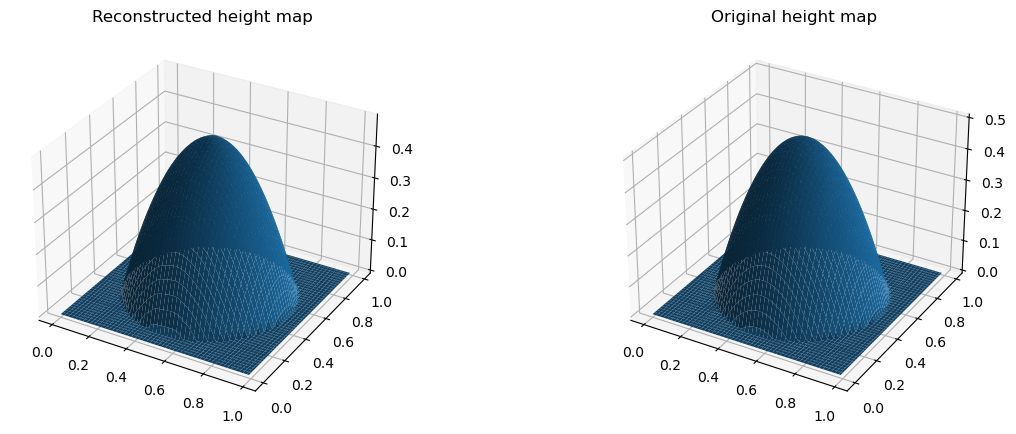

In [27]:
fig = plt.figure(figsize=[14,5])

ax = fig.add_subplot(121,projection='3d')
plt.title('Reconstructed height map')
ax.plot_surface(X,Y,U);

ax = fig.add_subplot(122,projection='3d')
plt.title('Original height map')
ax.plot_surface(X,Y,height);

## 4. GPU acceleration

The code presented in this notebook is far from efficient, and a basic gpu implementation allows to improve computation time by several orders of magnitude. It is provided in the agd library.

In [28]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError("cupy module not found")
from agd.Eikonal.HFM_CUDA import ShapeFromShading

DeliberateNotebookError: cupy module not found

In [34]:
height = ThreeBumps(X,Y)
Intensity,Omega = GenerateRHS(height,params)

Computation is basically instantaneous, even on much larger test cases.

In [59]:
%%time
sol = ShapeFromShading.Solve(Intensity,Omega,10*Omega,params).get()

Wall time: 12.9 ms


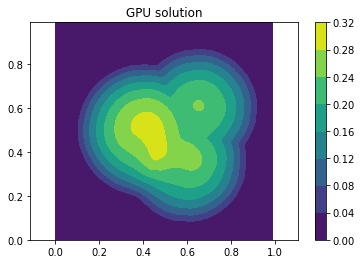

In [55]:
plt.title("GPU solution"); plt.axis("equal")
plt.contourf(X,Y,sol); plt.colorbar();

We can check that the solution is correct by looking at the residue of the numerical scheme.

In [57]:
residue = ShapeFromShading.EvalScheme(Intensity,sol,params,mask=Omega)
max_residue = np.max(np.abs(residue))
assert max_residue<1e-4
print("Largest residue : ",max_residue)

Largest residue :  2.6794602416058133e-05
